In [2]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)

# Load all images and tags found in DockerHub

In [ ]:
df = pd.read_csv('../../data/prepared_data/compact.csv.gz')

In [ ]:
df.query('kind=="official"')[['image','hash']].image.size

In [6]:
df.query('kind=="official"')[['image','hash']].set_index('image').drop_duplicates().shape

(12427, 1)

In [7]:
df.query('kind=="community"')[['image','hash']].image.size

5718715

In [8]:
df.query('kind=="community"')[['image','hash']].set_index('image').drop_duplicates().shape

(4381972, 1)

# Load images used in the study

In [2]:
images = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                    usecols = ['image','last_updated','type','release'])
images.drop_duplicates(inplace=True)
images.shape

(140498, 4)

In [3]:
images['slug'] = images['image'].apply(lambda x: '/'.join(x.split(':')[0:2]))

In [4]:
images.replace({'type': type_map}, inplace=True)
images.replace({'release': release_map}, inplace=True)

In [4]:
images.slug.unique().size

14007

In [34]:
print(images.query('type == "o"').image.unique().size, images.query('type == "c"').image.unique().size)

(9330, 131168)

# Load image popularity

In [ ]:
pop = pd.concat([pd.read_csv('../../data/images_tags/'+file+'.zip', usecols=['slug','popularity']) 
                        for file in ['official_images','community_images']])
pop.shape

In [ ]:
pop.popularity.describe().apply(lambda x: format(x, 'f'))

In [ ]:
mask = pop.slug.isin(images.slug)
pop = pop[mask]

In [ ]:
images = (images
          .merge(pop,
                on = 'slug',
                how = 'left')
         )
images.shape

In [ ]:
images.popularity.describe().apply(lambda x: format(x, 'f'))

## Let's check when images were last updated

In [5]:
images = images.query('last_updated != "None"')
images['last_updated'] = pd.to_datetime(images['last_updated'])

In [22]:
df_tmp=(images.
        groupby(['release','last_updated','type']).
        count().
        reset_index()
       )

df_tmp = (df_tmp
          .pivot_table(index=['last_updated','type'], columns='release', values='image')
#          .fillna(method='ffill')
          .fillna(0)
          .reset_index())

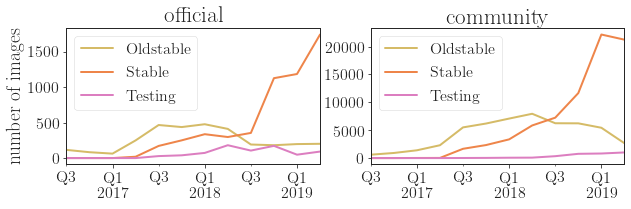

In [95]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False)
fig.set_size_inches(10,2.5)
for j, genre in enumerate(['official','community']):
    df_=(df_tmp
         .query('type =="{}"'.format(genre))
         .groupby(pd.Grouper(key='last_updated', freq='1M'))[['Oldstable','Stable','Testing']]
         .agg(sum)
         .cumsum()
        )   
    df_ = df_/len(images.query('type =="'+genre+'"'))
    
    ax=df_.plot(ax=axes[j], linewidth=2, colors=[colors[x] for x in ['Oldstable','Stable','Testing']])
    print(df_.tail(1))
    if j==0:
        ax.set_ylabel('proportion of images')
        ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
    ax.set(
        xlabel='',
        title=genre,
        xlim=date_period,
    )
    
    minorLocator   = MultipleLocator(3)
    ax.xaxis.set_minor_locator(minorLocator)
ax.legend('').remove()    


In [104]:
for j, genre in enumerate(['official','community']):
    df_=(df_tmp
         .groupby(pd.Grouper(key='last_updated', freq='1M'))[['Oldstable','Stable','Testing']]
         .agg(sum)
         .cumsum()
        )  
    # Compute R²

    for x in ['Oldstable','Stable','Testing']:
        print(genre,x)
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_.reset_index().index,
                               df_[x].values)
        print ("r-squared:", r_value**2)

        df_test = df_.query(x+'>0')
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_test.reset_index().index,
                               np.log(df_test[x].values))
        print ("r-squared:", r_value**2)
    break

year
2016     2.132905
2017    18.531618
2018    42.047160
2019    37.288317
Name: image, dtype: float64
year
2016     1.161124
2017    14.850647
2018    43.339737
2019    40.648491
Name: image, dtype: float64


# Let's check the Distributions of analyzed images

In [2]:
packages = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['image','package','type','version','release'])
packages.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(46272487, 5)

In [3]:
packages.release.unique()

array(['stretch', 'buster', 'jessie'], dtype=object)

In [5]:
'number of images', packages.image.unique().size

('number of images', 140498)

In [6]:
packages[['image','type']].drop_duplicates().groupby('type').count()

,image
type,
c,131168
o,9330


In [8]:
packages[['image','type','release']].drop_duplicates().groupby(['type','release']).count()

image
type release       
c    buster    3114
     jessie   52520
     stretch  75534
o    buster     741
     jessie    3085
     stretch   5504

In [9]:
packages[['image','release']].drop_duplicates().groupby('release').count()

,image
release,
buster,3855
jessie,55605
stretch,81038


In [6]:
packages.query('type == "o"').shape, packages.query('type == "c"').shape

((2042387, 5), (44230100, 5))

In [15]:
packages.query('type == "o"').groupby('image').count()[['package']].package.median()

185.0

In [14]:
packages.query('type == "c"').groupby('image').count()[['package']].package.median()

377.0

# What kind of vulnerabilities we have in the dataset?

In [4]:
# From DEBIAN SECURITY TRACKER
import json as js
import codecs
vulnerabilities=js.load(codecs.open('../../data/prepared_data/vuls_extracted_20190830.json', 'r', 'utf-8'))

In [7]:
sum([len(vulnerabilities[x]) for x in vulnerabilities])

29111

In [9]:
vuls = pd.read_csv('../../data/for_analysis/vulnerabilities.csv')
vuls = vuls.drop('archive', axis=1).drop_duplicates()
vuls.shape

(63601, 7)

In [10]:
urgency_map={'low**':'Low',
            'low*':'Low',
            'low':'Low',
            'medium**':'Medium',
            'medium**':'Medium',
            'medium':'Medium',
            'high**':'High',
            'high*':'High',
            'high':'High',
            'unimportant': pd.np.nan,
            'not yet assigned': pd.np.nan,
            'end-of-life': pd.np.nan,
           }

vuls = vuls.query('status != "undetermined"').copy()
vuls = (vuls
        .replace({'urgency': urgency_map})
        .dropna(subset=['urgency'])
        .drop_duplicates()
       )

In [11]:
vuls.cve.unique().size

5119

In [12]:
vuls = vuls[['urgency','status','cve']].drop_duplicates()

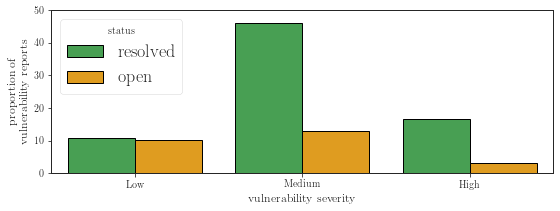

In [21]:
df_tmp=vuls.groupby(['urgency','status']).count().reset_index()
df_tmp['cve']=df_tmp['cve']*100.0/len(vuls)
df_tmp=df_tmp.sort_values('urgency', ascending=False)

ax = sns.barplot(x="urgency", 
                 y="cve", 
                 hue="status", 
                 order=['Low','Medium','High'],
                 hue_order=['resolved', 'open'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(9,3)
ax.set_xlabel("vulnerability severity ")
ax.set_ylabel('proportion of \nvulnerability reports')
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.yticks(np.arange(0, 60, 10))

ax.legend(loc='upper left', fontsize=18, title='status')
#ax.figure.savefig('../../figures/all_vuls.pdf', bbox_inches='tight', facecolor='white')

In [14]:
vuls.groupby(['status']).count().cve*100.0/len(vuls)

status
open        26.645716
resolved    73.354284
Name: cve, dtype: float64

In [15]:
vuls.groupby(['status']).count().cve

status
open        1611
resolved    4435
Name: cve, dtype: int64

In [16]:
vuls.groupby(['urgency']).count().cve*100.0/len(vuls)

urgency
High      19.798214
Low       21.055243
Medium    59.146543
Name: cve, dtype: float64

# What kind of bugs we have in the dataset?

In [6]:
bugs = pd.read_csv('../../data/for_analysis/bugs.csv')
bugs.drop_duplicates(inplace=True)
bugs= bugs.fillna('undefined')
bugs.shape

(371639, 10)

In [7]:
bugs.debianbug.unique().size

45953

In [8]:
def split_forwarded(status, fixed_in):
    if status == 'forwarded':
        if fixed_in == 'undefined':
            return 'open'
        else:
            return 'resolved'
    elif status == "pending":
        return 'open'
    else:
        return 'resolved'
bugs['status'] = bugs.apply(lambda d: split_forwarded(d['status'],d['fixed_in']), axis=1)

In [9]:
bugs = bugs[['debianbug','status','severity']].drop_duplicates()

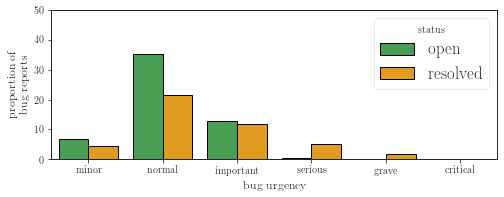

In [10]:
df_tmp=bugs.groupby(['severity','status']).count().reset_index()
df_tmp['debianbug']=df_tmp['debianbug']*100.0/len(bugs)
df_tmp=df_tmp.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="debianbug", 
                 hue="status", 
                 hue_order = ['open','resolved'],
                 order=['minor', 'normal', 'important', 'serious','grave','critical'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(8,2.75)
ax.set_xlabel("bug urgency")
ax.set_ylabel('proportion of \nbug reports')
for patch in ax.patches:
    patch.set_edgecolor('black')
plt.yticks(np.arange(0, 60, 10))

ax.legend(loc='upper right', fontsize=17, title="status")

In [12]:
bugs.groupby(['status']).count().debianbug*100.0/len(bugs)

status
open        55.45231
resolved    44.54769
Name: debianbug, dtype: float64

In [13]:
bugs.groupby(['status']).count().debianbug

status
open        25482
resolved    20471
Name: debianbug, dtype: int64

In [14]:
bugs.groupby(['severity']).count().debianbug*100.0/len(bugs)

severity
critical      0.217614
grave         2.008574
important    24.575109
minor        11.163580
normal       56.777577
serious       5.257546
Name: debianbug, dtype: float64

# Let's group bugs into two groups

In [15]:
severity_map={'minor':'Lower',
            'normal':'Lower',
            'important':'Higher',
            'grave':'Higher',
            'serious':'Higher',
            'critical':'Higher',
           }

bugs = (bugs
        .replace({'severity': severity_map})
        .drop_duplicates()
       )

Text(0.18, 1.15, 'Status:')

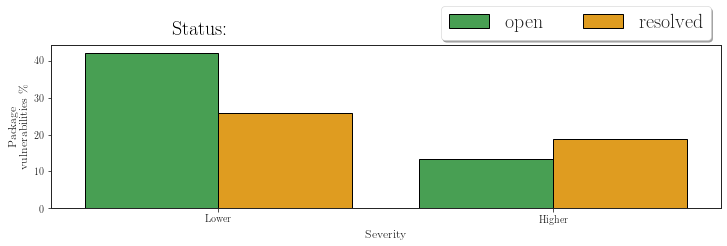

In [16]:
df_tmp=bugs.groupby(['severity','status']).count().reset_index()
df_tmp['debianbug']=df_tmp['debianbug']*100.0/len(bugs)
df_tmp=df_tmp.sort_values('severity', ascending=False)

ax = sns.barplot(x="severity", 
                 y="debianbug", 
                 hue="status", 
                 hue_order = ['open','resolved'],
                 data=df_tmp, 
                 palette=flatui, 
                 linewidth=1)
ax.figure.set_size_inches(12,3)
ax.set_xlabel("Severity")
ax.set_ylabel('Package \n vulnerabilities \%')
for patch in ax.patches:
    patch.set_edgecolor('black')
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fontsize=20, fancybox=True, shadow=True)
ax.text(0.18, 1.15, 'Status:', transform=ax.transAxes, fontsize=20,
        verticalalignment='top', color='black')